In [18]:
import numpy as np
import pandas as pd
import pymssql
import matplotlib.pyplot as plt

$ MSSQL DB Data Import 및 전처리



In [19]:
conn = pymssql.connect(server='localhost', user='admin', password='qaz123!@#', database='test_kt', as_dict = False, port = 1433)

In [20]:
sql_statement = 'SELECT * FROM dbo.test_kt'
df = pd.read_sql(sql=sql_statement, con=conn)

In [4]:
type(df.iloc[0, 4])

pandas._libs.tslibs.timestamps.Timestamp

In [21]:
df = df.drop(['_QUALITY', '_NUMERICID', 'id'], axis=1)
df['_NAME'] = df['_NAME'].apply(lambda x: x.split('LTE.')[-1])
df = df.sort_values(by = '_NAME', ascending = True)
from datetime import datetime
df['_TIMESTAMP'] = pd.to_datetime(df['_TIMESTAMP'].astype('str'))
df['_VALUE'] = df['_VALUE'].astype('str').astype('int64')
df

,_NAME,_VALUE,_TIMESTAMP
0,Tag1,43264,2020-03-27 14:08:41.237
140354,Tag1,45252,2020-03-27 14:41:43.257
4700,Tag1,43380,2020-03-27 14:10:36.237
140447,Tag1,45253,2020-03-27 14:41:44.257
37685,Tag1,43846,2020-03-27 14:18:20.237
...,...,...,...
98752,Tag99,44642,2020-03-27 14:31:38.257
10502,Tag99,43434,2020-03-27 14:11:34.253
227660,Tag99,46433,2020-03-27 15:01:24.273
227960,Tag99,46436,2020-03-27 15:01:27.273


In [22]:
type(df.iloc[0, 2])

pandas._libs.tslibs.timestamps.Timestamp

$$ Tag 번호 선택 및 정렬

In [23]:
df = df[df['_NAME'].isin(['Tag1'])]
df = df.sort_values(by = '_TIMESTAMP', ascending = True)
df = df.reset_index()
df = df.drop(['index'], axis=1)
df

,_NAME,_VALUE,_TIMESTAMP
0,Tag1,43264,2020-03-27 14:08:41.237
1,Tag1,43265,2020-03-27 14:08:42.237
2,Tag1,43266,2020-03-27 14:08:43.237
3,Tag1,43332,2020-03-27 14:09:48.237
4,Tag1,43333,2020-03-27 14:09:49.237
...,...,...,...
2612,Tag1,46896,2020-03-27 15:09:05.260
2613,Tag1,46897,2020-03-27 15:09:06.260
2614,Tag1,46898,2020-03-27 15:09:07.260
2615,Tag1,46899,2020-03-27 15:09:08.260


In [24]:
for col in df.columns:
    print(col, ':', sum(df[col].isna()), '/', len(df))

_NAME : 0 / 2617
_VALUE : 0 / 2617
_TIMESTAMP : 0 / 2617


In [25]:
for col in df.columns:
    print(col, ':', len(df[col].value_counts()), '/', len(df))

_NAME : 1 / 2617
_VALUE : 2617 / 2617
_TIMESTAMP : 2617 / 2617


In [26]:
df['_VALUE'] = df['_VALUE'].apply(lambda x: x - (df['_VALUE'][0]-1))
df

,_NAME,_VALUE,_TIMESTAMP
0,Tag1,1,2020-03-27 14:08:41.237
1,Tag1,2,2020-03-27 14:08:42.237
2,Tag1,3,2020-03-27 14:08:43.237
3,Tag1,69,2020-03-27 14:09:48.237
4,Tag1,70,2020-03-27 14:09:49.237
...,...,...,...
2612,Tag1,3633,2020-03-27 15:09:05.260
2613,Tag1,3634,2020-03-27 15:09:06.260
2614,Tag1,3635,2020-03-27 15:09:07.260
2615,Tag1,3636,2020-03-27 15:09:08.260


In [27]:
end = len(df)-1
df.iloc[end, 1] - len(df)

1020

In [28]:
df.iloc[0, 2]

Timestamp('2020-03-27 14:08:41.237000')

$$$ Value (1씩 증가) 확인 / 통신 시간 확인

In [29]:
#pd.set_option('display.max_rows', -1)
pastTime = df.iloc[0,2]
past = 0
diff_list = []
diffTime_list =[]
df_sample = pd.DataFrame(columns = ("Num Index","Over1 Val", "To be Seq. Num", "Now Val", "Past Time", "Now Time", "Diff-1-Over"))

for i in df.index:
    row_val = df.loc[i, '_VALUE']
    val = row_val - past
    diff_list.append(val)
    
    if val > 1:
        diff_1over = df.loc[i, '_TIMESTAMP'] - df.loc[i-1, '_TIMESTAMP']
        addrow = [i, val, past + 1, row_val, df.loc[i-1, '_TIMESTAMP'], df.loc[i, '_TIMESTAMP'], diff_1over]
        df_sample.loc[len(df_sample)] = addrow
        
    past = row_val
    
    row_time = df.loc[i, '_TIMESTAMP']
    valTime = row_time - pastTime
    diffTime_list.append(valTime)
    
    pastTime = row_time
    
df["diff-value"] = diff_list
df["diff-Time"] = diffTime_list
# df["diff-Time"] = pd.to_datetime(df['diff-Time'])
# df["diff-Time"] = (df["diff-Time"].dt.microsecond)/1000
# df['diff-value'].unique()
df

,_NAME,_VALUE,_TIMESTAMP,diff-value,diff-Time
0,Tag1,1,2020-03-27 14:08:41.237,1,00:00:00
1,Tag1,2,2020-03-27 14:08:42.237,1,00:00:01
2,Tag1,3,2020-03-27 14:08:43.237,1,00:00:01
3,Tag1,69,2020-03-27 14:09:48.237,66,00:01:05
4,Tag1,70,2020-03-27 14:09:49.237,1,00:00:01
...,...,...,...,...,...
2612,Tag1,3633,2020-03-27 15:09:05.260,1,00:00:01
2613,Tag1,3634,2020-03-27 15:09:06.260,1,00:00:01
2614,Tag1,3635,2020-03-27 15:09:07.260,1,00:00:01
2615,Tag1,3636,2020-03-27 15:09:08.260,1,00:00:01


$$$$ Value 1 이상인 값(=지연)이 얼마나 나타나는지 확인

In [30]:
df_sample

,Num Index,Over1 Val,To be Seq. Num,Now Val,Past Time,Now Time,Diff-1-Over
0,3,66,4,69,2020-03-27 14:08:43.237,2020-03-27 14:09:48.237,00:01:05
1,8,2,74,75,2020-03-27 14:09:52.237,2020-03-27 14:09:54.237,00:00:02
2,9,4,76,79,2020-03-27 14:09:54.237,2020-03-27 14:09:58.237,00:00:04
3,164,66,234,299,2020-03-27 14:12:32.237,2020-03-27 14:13:37.237,00:01:05
4,170,2,305,306,2020-03-27 14:13:42.237,2020-03-27 14:13:44.237,00:00:02
5,171,3,307,309,2020-03-27 14:13:44.237,2020-03-27 14:13:47.237,00:00:03
6,328,65,466,530,2020-03-27 14:16:23.237,2020-03-27 14:17:27.457,00:01:04.220000
7,333,2,535,536,2020-03-27 14:17:31.237,2020-03-27 14:17:33.237,00:00:02
8,334,4,537,540,2020-03-27 14:17:33.237,2020-03-27 14:17:37.237,00:00:04
9,493,67,699,765,2020-03-27 14:20:15.237,2020-03-27 14:21:21.237,00:01:06


Text(0.5, 1.02, 'Line Plot')

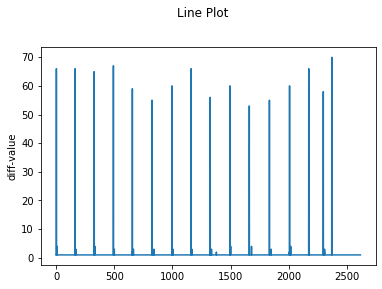

In [31]:
import seaborn as sns

g = sns.lineplot(x = df.index, y = df["diff-value"], data = df)
plt.suptitle("Line Plot", y=1.02)

Text(0.5, 1.02, 'LIne Plot')

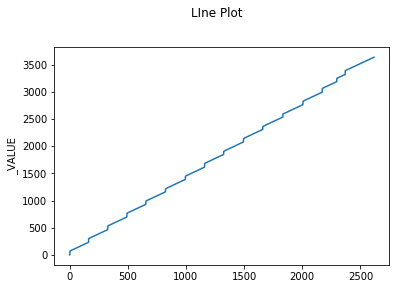

In [32]:
g = sns.lineplot(x = df.index, y = df["_VALUE"], data = df)
plt.suptitle("LIne Plot", y=1.02)

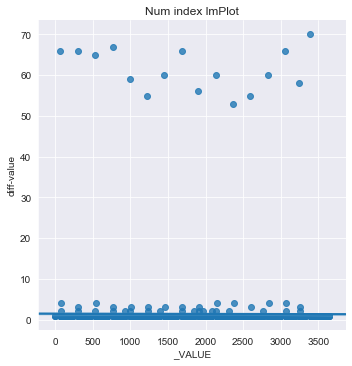

In [33]:
sns.set_style("darkgrid")
sns.lmplot(x="_VALUE", y = "diff-value", data = df)
plt.title("Num index lmPlot")
plt.show()

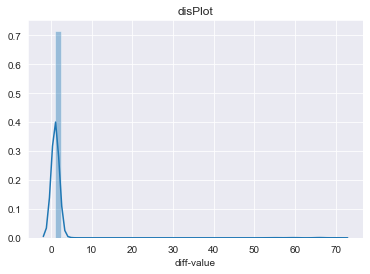

In [34]:
sns.distplot(df["diff-value"])
plt.title("disPlot")
plt.show()

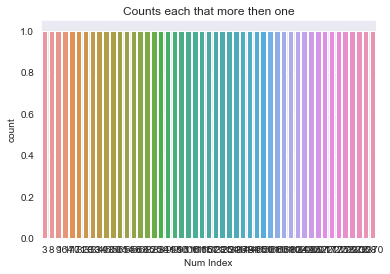

In [35]:
sns.countplot(x="Num Index", data=df_sample)
plt.title("Counts each that more then one")
plt.show()

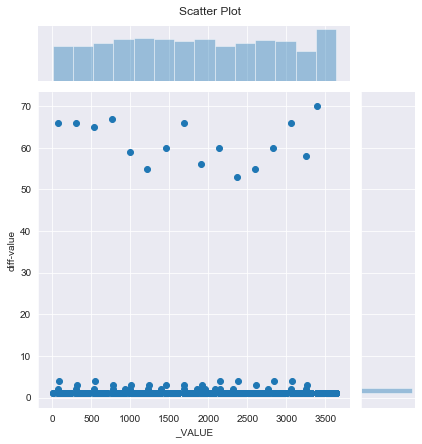

In [36]:
sns.jointplot(x="_VALUE", y="diff-value", data=df)
plt.suptitle("Scatter Plot", y=1.02)
plt.show()

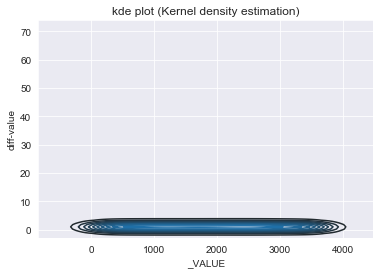

In [37]:
sns.kdeplot(df["_VALUE"], df["diff-value"])
plt.title("kde plot (Kernel density estimation)")
plt.show()

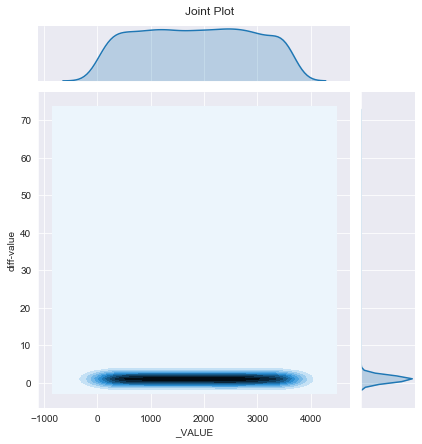

In [38]:
sns.jointplot(x="_VALUE", y="diff-value", data=df, kind="kde")
plt.suptitle("Joint Plot", y=1.02)
plt.show()

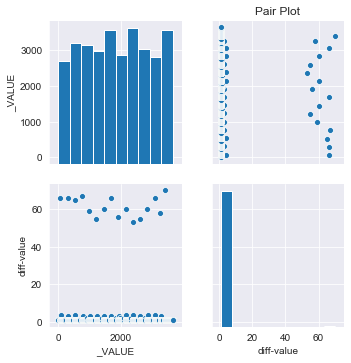

In [39]:
sns.pairplot(df)
plt.title("Pair Plot")
plt.show()

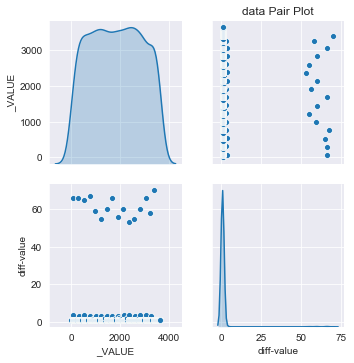

In [40]:
sns.pairplot(df, palette="hue1", diag_kind="kde")
# sns.pairplot(df, palette="hue1")
plt.title("data Pair Plot")
plt.show()